In [1]:
from pylab import *
from scipy.special import erf
from random import uniform
from scipy.optimize import curve_fit

## Diffusion 1D transitoire : illustration avec la chronoampérométrie (équation de Cottrel)

Soit une cellule électrochimique à trois électrodes (permettant de faire circuler un courant et de contrôler le potentiel de l'électrode de travail) contenant une solution de ferri (Fe(III)) et ferrocyanure (Fe(II)) équimolaire (0,001 mol/L) :

<img src="setup.png" alt="Drawing" style="width: 400px;"/>

Effectuons une voltammétrie cyclique (sans agitation de la solution):

<img src="volta.png" alt="Drawing" style="width: 400px;"/>

Considérons l'oxydation du Fe(II) sur ce tracé, Fe(II) $\rightarrow$ Fe(III) + e$^-$

<img src="volta2.png" alt="Drawing" style="width: 400px;"/>

Cherchons à déterminer la concentration en réducteur (c'est à dire en Fe(II)) à la surface de l'électrode pendant le balayage de potentiel anodique (oxydation).

On peut utiliser la loi de Nernst (valable pour cinétique rapide) :

$E = E_{I=0} + \dfrac{RT}{nF}\mathrm{ln}\left(\dfrac{c_{ox,s}}{c_{red,s}}\right)$

Pour simplifier, on suppose que $c_{ox,s} \approx 0,001$ mol/L (la concentration dans la solution)

On peut donc déterminer $c_{red,s}$ ([Fe(II)]) pour toutes valeurs de potentiel $E$ :

Text(0, 0.5, '$c_{red,s}$ (mol/L)')

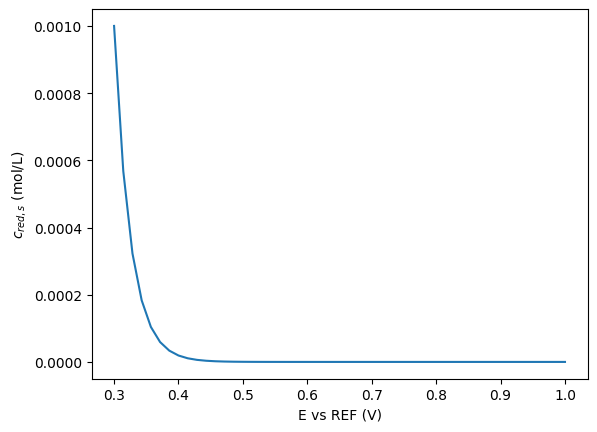

In [2]:
#constantes
F = 96500 #C/mol
n = 1
R = 8.314 #J/mol/K
T = 20+273.15 #K
E0 = 0.3 

cox_s = 0.001 #mol/L
E = linspace(E0,1,50)

cred_s = cox_s*exp(-n*F*(E-E0)/(R*T))

figure()
plot(E,cred_s)
xlabel('E vs REF (V)')
ylabel('$c_{red,s}$ (mol/L)')

Pour les potentiels $E$ supérieurs à 0,45 V, on peut considérer que la concentration en Fe(II) à la surface de l'électrode est ~0

Appliquer un potentiel supérieur à 0,45 V revient donc à imposer la concentration  <ins>à la surface de l'électrode</ins> comme étant égale à ~0

On va exploiter cela pour imposer d'un coup une concentration égale à 0 à la surface de l'électrode et suivre l'évolution du courant. 
Cette méthode de polarisation premet notamment de déterminer le coefficient de diffusion de l'espèce électroactive (Fe(II) ici).

### Méthode de chronoampérométrie

Avant $t=0$, le circuit est ouvert ($I=0$) et $E=E_{I=0}$

A $t=0$, on applique $E=$ 0,5 V pendant 30 s et on mesure le courant $I$ en fonction du temps :

Text(0, 0.5, '$E(t)$ V')

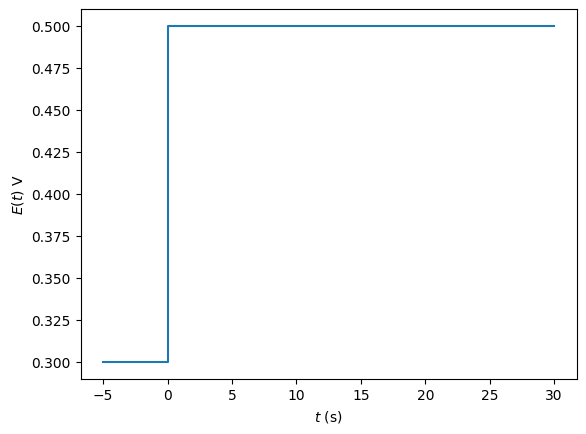

In [3]:
Et = array([E0, E0, 0.5, 0.5])
t = array([-5,0,0,30])

plot(t,Et)
xlabel('$t$ (s)')
ylabel('$E(t)$ V')


In [4]:
#generation d'un signal exp :
ci = 0.001 #mol/L
c0 = 0
D = 10*1e-010 #m^2/s
nt= 20
S = 10*1e-06 #m^2

texp = linspace(0,30,nt) #s
I = n*F*S*D*(ci-c0)*(2/pi**0.5)*(1/(2*(D*texp)**0.5))

Iexp = I*0
for i in range(size(I)):
    Iexp[i] = I[i] *( 1 + uniform(-0.05,0.05))

savetxt('I_t_exp.dat',[texp,Iexp])

/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/4082886338.py:9: RuntimeWarning: divide by zero encountered in divide
  I = n*F*S*D*(ci-c0)*(2/pi**0.5)*(1/(2*(D*texp)**0.5))
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/4082886338.py:11: RuntimeWarning: invalid value encountered in multiply
  Iexp = I*0


(-8.0, 32.0)

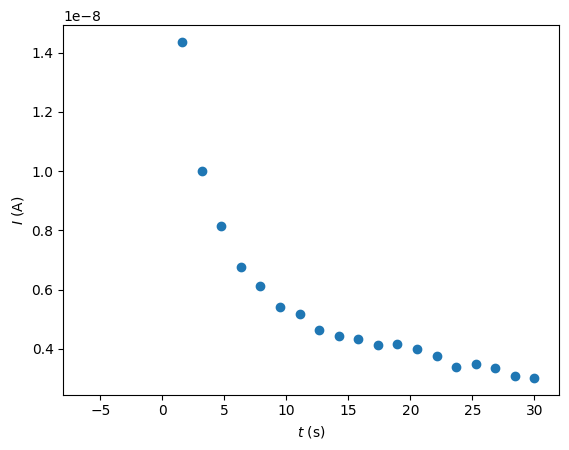

In [5]:
#chargement des données exp
data = loadtxt('I_t_exp.dat',unpack = True)

texp = data[:,0]
Iexp = data[:,1]

figure()
plot(texp,Iexp,'o')
xlabel('$t$ (s)')
ylabel('$I$ (A)')
xlim([-8,32])

Le courant diminue et tend vers 0

Pourquoi cette diminution ?

Cela vient du fait, que à cause de la polarisation de l'électrode, il y a un gradient de concentration à la surface de l'électrode et donc un flux de diffusion qui correspond à un flux de matière converti électrochimiquement à l'électrode.

Voici un représentation schématiques de l'évolution temporelle du profil de concnetration à la surface de l'électrode :


<img src="profiles_scheme.png" alt="Drawing" style="width: 300px;"/>

On voit bien le gradient de concentration $\dfrac{\partial c}{\partial x}$, notamment en $x=0$ là où il est le plus grand en valeur absolue


La situation de diffusion est unidimensionnelle 1D car (comme on va le voir juste après) le gradient de concentration s'établie sur une faible longeur devant la taille (surface) de l'électrode, schématiquement la situation est la suivante (l'électrode apparait en gris et la solution en bleu) :



<img src="schema_1D.png" alt="Drawing" style="width: 300px;"/>


Avec la condition initiale $c(t=0,x)=c_i =0,001$ pour $ x \ge 0 $

et la condition limite $c(x=0,t\ge0)=c_0=0$

le problème de transport dans la solution (équation de conservation de la matière version locale) $\dfrac{\partial c}{\partial t} = D \dfrac{\partial^2 c}{\partial x^2}$ admet la solution suivante (cf cours) : 

$c(t,x) = (c_i-c_0) \mathrm{erf} \left( \dfrac{x}{2\sqrt{Dt}}\right) + c_0$

On peut tracer des profils de concentration à partir de cette relation, en supposant $D$ = 5.10$^{-10}$ m$^2$/s (typiquement l'ordre de grandeur en milieu liquide) :

/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/1036048906.py:11: RuntimeWarning: divide by zero encountered in divide
  c[i,:] = (ci-c0)*erf(x/(2*(D*t_[i])**0.5))+c0
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/1036048906.py:11: RuntimeWarning: invalid value encountered in divide
  c[i,:] = (ci-c0)*erf(x/(2*(D*t_[i])**0.5))+c0


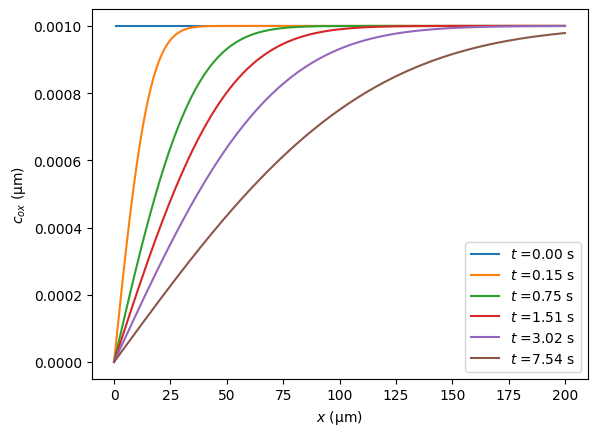

In [6]:
D = 5*1e-010 #m^2/s
ci = 0.001 #mol/L
c0 = 0
nx = 200
nt=200
x = linspace(0,200*1e-06,nx) #m
t_ = linspace(0,30,nt) #s
c = zeros((nt,nx))

for i in range(size(t_)) :
    c[i,:] = (ci-c0)*erf(x/(2*(D*t_[i])**0.5))+c0

figure()
plot(x*1e+06,c[0,:],label='$t$ ='+str("%.2f" % t_[0])+' s')
plot(x*1e+06,c[1,:],label='$t$ ='+str("%.2f" % t_[1])+' s')
plot(x*1e+06,c[5,:],label='$t$ ='+str("%.2f" % t_[5])+' s')
plot(x*1e+06,c[10,:],label='$t$ ='+str("%.2f" % t_[10])+' s')
plot(x*1e+06,c[20,:],label='$t$ ='+str("%.2f" % t_[20])+' s')
plot(x*1e+06,c[50,:],label='$t$ ='+str("%.2f" % t_[50])+' s')

xlabel('$x$ (µm)')
ylabel('$c_{ox}$ (µm)')
legend()

A partir de ces évolutions théoriques de $c(t,x)$, on peut calculer le gradient de concentration $\dfrac{\partial c}{\partial x}$, en $x$ = 0, en fonction du temps et donc on peut en déduire le flux de diffusion donné par la loi de Fick :

Flux de diffusion (mol/s) = $D S \dfrac{\partial c}{\partial x} $ (correspondant au flux de consomation de Fe(II))

Ensuite on peut utiliser la loi de Faraday pour convertir ce flux de matière en courant électrique :

$I = (nF) D S \dfrac{\partial c}{\partial x} $, où le gradient de concentration est évalué en $x=0$ :

On obtient l'équation de Cottrel :

$I = (nF) D^{0.5} S \dfrac{c_i}{\sqrt{\pi t}}$

Dans l'expérience, la surface d'électrode $S$ était de 1 mm$^2$

/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/546912297.py:3: RuntimeWarning: divide by zero encountered in divide
  I = n*F*S*D**0.5*ci*(1/(pi*t_)**0.5)


Text(0, 0.5, '$I$ (A)')

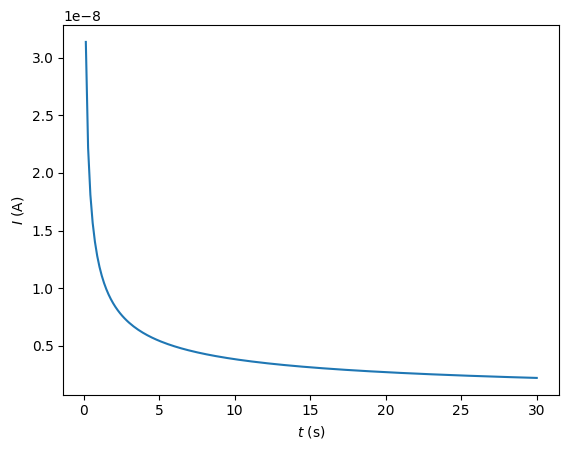

In [7]:
S = 10*1e-06 #m^2

I = n*F*S*D**0.5*ci*(1/(pi*t_)**0.5)
figure()
plot(t_,I)
xlabel('$t$ (s)')
ylabel('$I$ (A)')

On peut ajuster ce tracé théorique $I(t)$ sur les mesures expériemntales pour remonter à $D$ (celui du Fe(II) ici).

Une façon de faire est de tracer $I$ en fonction de $1/\sqrt{t}$ pour avoir des tracés linéaires :

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/1427505044.py:6: SyntaxWarning: invalid escape sequence '\s'
  xlabel('$1/\sqrt{t}$ (s$^{-0.5}$)')
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/1427505044.py:2: RuntimeWarning: divide by zero encountered in divide
  plot(1/t_**0.5,I, label = 'tracé théorique')
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/1427505044.py:3: RuntimeWarning: divide by zero encountered in divide
  plot(1/texp**0.5,Iexp, 'o', label = 'tracé expériemental')


Text(0, 0.5, '$I$ (A)')

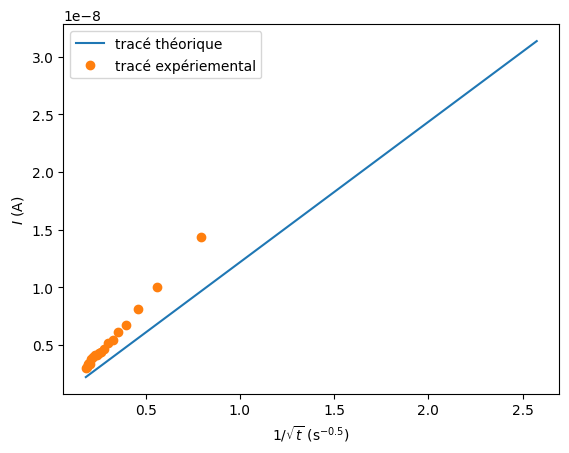

In [8]:
figure()
plot(1/t_**0.5,I, label = 'tracé théorique')
plot(1/texp**0.5,Iexp, 'o', label = 'tracé expériemental')

legend()
xlabel('$1/\sqrt{t}$ (s$^{-0.5}$)')
ylabel('$I$ (A)')

In [9]:
def func(rac_t,D):
    I = n*F*S*D**0.5*(ci-c0)*(1/pi**0.5)* rac_t
    return I

popt, pcov = curve_fit(func,1/texp[1:]**0.5,Iexp[1:],p0=5*1e-010)

D = popt[0]
print('La valeur du coefficient de diffusion est : '+str(D)+' m^2/s')

La valeur du coefficient de diffusion est : 1.0344501806634723e-09 m^2/s


On peut recalculer $I$ théorique et le superposer au tracé expérimental

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/2325348110.py:8: SyntaxWarning: invalid escape sequence '\s'
  xlabel('$1/\sqrt{t}$ (s$^{-0.5}$)')
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/2325348110.py:1: RuntimeWarning: divide by zero encountered in divide
  I = n*F*S*D**0.5*(ci-c0)*(2/pi**0.5)*(1/(2*t_**0.5))
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/2325348110.py:4: RuntimeWarning: divide by zero encountered in divide
  plot(1/t_**0.5,I, label = 'tracé théorique')
/var/folders/dz/7wtml3850459dt3jd3xd3gq80000gn/T/ipykernel_14082/2325348110.py:5: RuntimeWarning: divide by zero encountered in divide
  plot(1/texp**0.5,Iexp, 'o', label = 'tracé expériemental')


Text(1, 5e-09, 'D=1.0344501806634723e-09m^2/s')

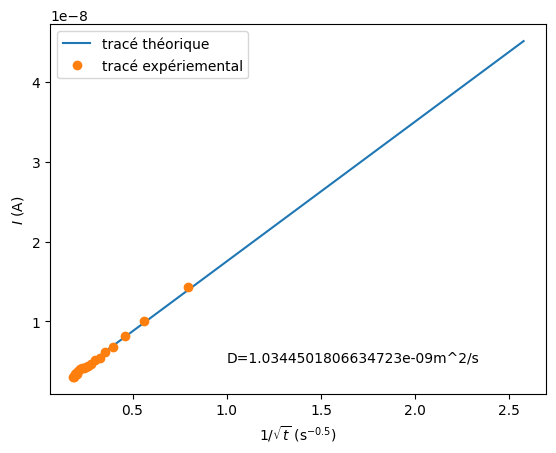

In [10]:
I = n*F*S*D**0.5*(ci-c0)*(2/pi**0.5)*(1/(2*t_**0.5))

figure()
plot(1/t_**0.5,I, label = 'tracé théorique')
plot(1/texp**0.5,Iexp, 'o', label = 'tracé expériemental')

legend()
xlabel('$1/\sqrt{t}$ (s$^{-0.5}$)')
ylabel('$I$ (A)')
text(1,0.5*1e-08, 'D='+str(D)+'m^2/s')